<a href="https://colab.research.google.com/github/albertomariapepe/Learning-Rotations/blob/main/Learning_Bivectors_from_Rotors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/pygae/clifford.git@master

  Cloning https://github.com/pygae/clifford.git (to revision master) to /tmp/pip-req-build-zzfxgoor
  Running command git clone -q https://github.com/pygae/clifford.git /tmp/pip-req-build-zzfxgoor
     |████████████████████████████████| 81kB 5.1MB/s 
  Created wheel for clifford: filename=clifford-1.4.0.dev0-cp37-none-any.whl size=156888 sha256=276d18421565383ddb62dc6a33b0586574b9873e0777617074d0a709a7e97442
  Stored in directory: /tmp/pip-ephem-wheel-cache-j10bhzg9/wheels/81/d0/f1/6422c3ef192b296a0055bcf7257d582555aaad0e9b8e810689
Successfully built clifford


In [ ]:
!pip install tensorflow_graphics

     |████████████████████████████████| 348kB 6.9MB/s 
     |████████████████████████████████| 634kB 12.4MB/s 
     |████████████████████████████████| 296kB 17.6MB/s 
     |████████████████████████████████| 81kB 9.8MB/s 
  Created wheel for OpenEXR: filename=OpenEXR-1.3.2-cp37-cp37m-linux_x86_64.whl size=189351 sha256=d895f663f359c8c1a409bca212cd4d4189c30b40dac8cb2664940a0b883976d9
  Stored in directory: /root/.cache/pip/wheels/41/06/9f/c7dc838815b0e7dfc7d7dc19cc3d677edb47594d8489adc62a
Successfully built OpenEXR
  Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='dense_3/BiasAdd:0', description="created by layer 'dense_3'")
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 34,051
Trainable params: 34,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
733/733 [==============================] - 14s 3ms/step - loss: 0.1497 - val_loss: 0.0388
Epoch 2/100
733/733 [==============================] - 2s 3ms/step - loss: 0.0375 - val_loss: 0.0273
Epoch 3/100
733/733 [==============================] - 2s 3ms/step - loss: 0.0328 - val_loss: 0.0263
Epoch 4/100
733/733 [==============================] - 2s 2ms/step - loss: 0.0338 - val_loss: 0.0229
Epoch 5/100
733/733 [==============================] - 2s 3ms/step - loss: 0.0240 - val_loss: 0.0250
Epoch 6/100
733/733 [==============================] - 2s 3ms/s

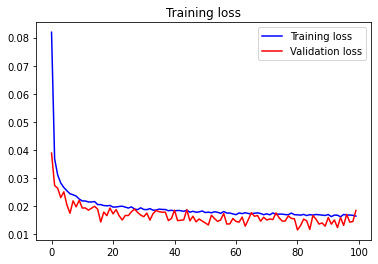

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: DeprecationWarning: Treating MultiVector objects like a sequence is deprecated. To access the coefficients as a sequence, use the `.value` attribute.


15.245397074373406
1.1154061491371945
0.5545881924835885


In [ ]:
from scipy.spatial.transform import Rotation as R
import numpy as np
from clifford.g3c import *
from clifford.tools.g3c import *
from clifford.tools.g3c.rotor_parameterisation import *
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from keras import backend as K
from sklearn.model_selection import train_test_split
from math import acos
import tensorflow as tf
from matplotlib import pyplot as plt
import keras
from math import e, pi
import tensorflow_graphics as tfg
import tensorflow_graphics.geometry.transformation as tfg_transformation

tot = int(1e5)
'''
#GENERATING THE RANDOM DATASET
i = 0

rot = []
b = []


for i in range(0,tot):

    Q = R.random(random_state = i).as_quat()
    Rot = Q[0] + Q[2]*e13 +Q[1]*e23 + Q[3]*e12

    #rot = np.append(rot, [Q[0], Q[2], Q[1], Q[3]] )
    #B = -2*general_logarithm(Rot)
    B = (1 - Rot)/(1+Rot)
    b = np.append(b, [B[6], B[7], B[10]])


#np.save('Bivectors_cayley.npy', b)
#np.save('Rotors.npy', rot)
'''
rot = np.load('Rotors.npy')
b = np.load('Bivectors_cayley.npy')

rot = np.reshape(rot, [tot, 4])   
b = np.reshape(b, [tot, 3])

#Train - Test Split
r_train, r_test = train_test_split(rot, test_size=0.33, shuffle=False)
b_train, b_test = train_test_split(b, test_size=0.33, shuffle=False)


TRAIN = b_train
TEST = b_test
out_size = 3

nb_epoch = 100
batch_size = 64


r_input = Input(shape=(4))
x = Dense(128)(r_input)
x = LeakyReLU(alpha=0.2)(x)
x = Dense(128)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dense(128)(x)
x = LeakyReLU(alpha=0.2)(x)
out = Dense(out_size)(x)
print(out)


model = keras.Model(r_input,  out)
model.summary()
model.compile(loss='mae', optimizer="adam")
#es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_train = model.fit(x = r_train, y = TRAIN, 
                        validation_split=0.3,
                        epochs=nb_epoch,
                        verbose=1,
                        batch_size=batch_size)


loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(nb_epoch)
plt.figure()
plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training loss')
plt.legend()
plt.show()

predicted = model.predict(r_test)

M = []
Langle = []

for i in range(0,int(tot*0.33)):
    B = predicted[i][0]*e12 +predicted[i][1]*e13 + predicted[i][2]*e23
    #Rot_pred = e**(-B/2)

    Rot_pred = (1-B)/(1+B)       
    
    #print(Rot_pred)
    B = TEST[i][0]*e12 +TEST[i][1]*e13 + TEST[i][2]*e23
    #Rot_real = e**(-B/2)
    Rot_real = (1-B)/(1+B) 

    #print(Rot_real)

    #print(Rot_real*~Rot_pred)
    cosine = (Rot_real*~Rot_pred)[0]
    #print(cosine)
    #print('-----------------')
    if cosine > 1:
        cosine = 1
    Langle = np.append(Langle, acos(cosine))
    if (acos(cosine)*180/pi) > 90:
        print(acos(cosine)*180/pi)


print(np.max(Langle)*180/pi)
print(np.average(Langle)*180/pi)
print(np.std(Langle)*180/pi)

In [ ]:
M = []
Langle = []

for i in range(0,2):
    B = predicted[i][0]*e12 +predicted[i][1]*e13 + predicted[i][2]*e23

    Rot_pred = (1-B)/(1+B) 
    B = TEST[i][0]*e12 +TEST[i][1]*e13 + TEST[i][2]*e23
    Rot_real = (1-B)/(1+B) 

    print(Rot_pred)
    #print(r_test[i])
    print(Rot_real)

    #print(Rot_real)
    #print('----')

    #R = Rot_real*~Rot_pred

    #print(Rot_real*~Rot_pred)
    cosine = (Rot_real*~Rot_pred)[0]
    #print(cosine)
    #print('-----------------')
    if cosine > 1:
        cosine = 1
    Langle = np.append(Langle, acos(cosine))


print(np.max(Langle)*180/pi)
print(np.average(Langle)*180/pi)
print(np.std(Langle)*180/pi)

0.61974 + (0.6759^e12) + (0.16953^e13) - (0.36102^e23)
0.63136 + (0.68152^e12) + (0.16304^e13) - (0.33217^e23)
-0.45463 - (0.23291^e12) + (0.40894^e13) + (0.7562^e23)
-0.43084 - (0.23321^e12) + (0.40789^e13) + (0.77046^e23)
1.8488222449984897
1.7196308141075942
0.1291914308908952


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Treating MultiVector objects like a sequence is deprecated. To access the coefficients as a sequence, use the `.value` attribute.


In [ ]:
Q = R.random(random_state = i).as_quat()
Rot = Q[0] + Q[2]*e13 +Q[1]*e23 + Q[3]*e12
Rot

B = (1 - Rot)/(1+Rot)
print(B)
print(B[6])
print(B[7])
print(B[10])

(0.28749^e12) + (0.14152^e13) + (0.16391^e23)
0.2874910510046326
0.1415182597456036
0.16391392132759539


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Treating MultiVector objects like a sequence is deprecated. To access the coefficients as a sequence, use the `.value` attribute.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Treating MultiVector objects like a sequence is deprecated. To access the coefficients as a sequence, use the `.value` attribute.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Treating MultiVector objects like a sequence is deprecated. To access the coefficients as a sequence, use the `.value` attribute.
  if __name__ == '__main__':
